In [26]:
import sys
sys.path.append("..")

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import torch
import torchvision
from torchvision.models import resnet50
import yaml

import datasets
from datasets import preprocessing
from utils import main_utils

In [2]:
class Args:
    rank = -1
    quiet = False

args = Args()

cfg = yaml.safe_load(open("../configs/main/avid-cma/kinetics/InstX-N1024-PosW-N64-Top32.yaml"))
logger, tb_writter, model_dir = main_utils.prep_environment(args, cfg)

In [3]:
cfg['model']['args']['checkpoint'] = '../checkpoints/AVID-CMA/kinetics/Cross-N1024/checkpoint.pth.tar'
model = main_utils.build_model(cfg['model'], logger)
state_dict = torch.load("../checkpoints/AVID-CMA/kinetics/Cross-N1024/checkpoint.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict({k.replace('module.', ''): state_dict['model'][k] for k in state_dict['model']})
model.eval()

AV_Wrapper(
  (video_model): R2Plus1D(
    (conv1): Sequential(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    )
    (conv2x): Sequential(
      (0): BasicR2P1DBlock(
        (spt_conv1): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        (spt_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (tmp_conv1): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        (tmp_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (spt_conv2): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        (spt_bn2): BatchNo

In [4]:
video_transform = preprocessing.VideoPrep_MSC_CJ(
            crop=(224, 224),
            augment=False,
            num_frames=0.5 * 16,
            pad_missing=True,
        )
audio_transform = [
    preprocessing.AudioPrep(
        trim_pad=True,
        duration=2,
        augment=False,
        missing_as_zero=True),
    preprocessing.LogSpectrogram(
        24000,
        n_fft=512,
        hop_size=1. / 100,
        normalize=True)
]

In [5]:
dataset = datasets.Kinetics(
    subset="val",
    return_video=True,
    video_clip_duration=0.5,
    video_fps=16,
    video_transform=video_transform,
    return_audio=True,
    audio_clip_duration=2,
    audio_fps=24000,
    audio_fps_out=64,
    audio_transform=audio_transform,
    max_offsync_augm=0,
    return_labels=True,
    return_index=True,
    mode='clip',
    clips_per_video=10,
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
    sampler=None
)

In [6]:
labels_val = []
codings_val = []
for sample in dataloader:
    with torch.no_grad():
        logits = model(sample["frames"], sample["audio"])
        video_enc = logits[0]
        audio_enc = logits[1]
        codings_val.append(torch.hstack([video_enc, audio_enc]))
        labels_val += [l.split("?")[-1] for l in sample["label"]]
        print(len(labels_val))
        
        
codings_val = torch.vstack(codings_val)

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3050


In [42]:
dataset_test = datasets.Kinetics(
    subset="test",
    return_video=True,
    video_clip_duration=0.5,
    video_fps=16,
    video_transform=video_transform,
    return_audio=True,
    audio_clip_duration=2,
    audio_fps=24000,
    audio_fps_out=64,
    audio_transform=audio_transform,
    max_offsync_augm=0,
    return_labels=True,
    return_index=True,
    mode='clip',
    clips_per_video=10,
)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
    sampler=None
)

In [43]:
labels_test = []
codings_test = []
for sample in dataloader_test:
    with torch.no_grad():
        logits = model(sample["frames"], sample["audio"])
        video_enc = logits[0]
        audio_enc = logits[1]
        codings_test.append(torch.hstack([video_enc, audio_enc]))
        labels_test += [l.split("?")[-1] for l in sample["label"]]
        print(len(labels_test))
        
        
codings_test = torch.vstack(codings_test)

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3170


In [44]:
tasks = [
    ["yoga", "tai chi"],
    ["cutting watermelon", "eating watermelon"],
    ["dancing macarena", "robot dancing"],
    ["playing bass guitar", "playing guitar", "strumming guitar", "tapping guitar"],
    ["playing clarinet", "playing flute"],
    ["skiing (not slalom or crosscountry)", "skiing crosscountry", "skiing slalom"],
    ["swimming backstroke", "swimming breast stroke", "swimming butterfly stroke"],
]

for task in tasks:
    print(f"\n{task}")
    
    val_mask = [l in task for l in labels_val]
    X_val = codings_val[val_mask, :]
    y_val = list(itertools.compress(labels_val, val_mask))
    
    test_mask = [l in task for l in labels_test]
    X_test = codings_test[test_mask, :]
    y_test = list(itertools.compress(labels_test, test_mask))

    linreg = LogisticRegression()
    linreg.fit(X_val, y_val)
    preds = linreg.predict_proba(X_test)
    print(f"Accuracy: {linreg.score(X_test, y_test)}")
    print(f"ROC AUC: {roc_auc_score(pd.get_dummies(y_test), preds)}")



['yoga', 'tai chi']
Accuracy: 0.7571428571428571
ROC AUC: 0.8459064327485379

['cutting watermelon', 'eating watermelon']
Accuracy: 0.8548387096774194
ROC AUC: 0.9343333333333332

['dancing macarena', 'robot dancing']
Accuracy: 0.6875
ROC AUC: 0.7658823529411765

['playing bass guitar', 'playing guitar', 'strumming guitar', 'tapping guitar']
Accuracy: 0.4014285714285714
ROC AUC: 0.6495895655270656

['playing clarinet', 'playing flute']
Accuracy: 0.7137931034482758
ROC AUC: 0.7503921568627451

['skiing (not slalom or crosscountry)', 'skiing crosscountry', 'skiing slalom']
Accuracy: 0.8333333333333334
ROC AUC: 0.89321875

['swimming backstroke', 'swimming breast stroke', 'swimming butterfly stroke']
Accuracy: 0.45714285714285713
ROC AUC: 0.6147340931874324


/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [49]:
# VIDEO ONLY 

tasks = [
    ["yoga", "tai chi"],
    ["cutting watermelon", "eating watermelon"],
    ["dancing macarena", "robot dancing"],
    ["playing bass guitar", "playing guitar", "strumming guitar", "tapping guitar"],
    ["playing clarinet", "playing flute"],
    ["skiing (not slalom or crosscountry)", "skiing crosscountry", "skiing slalom"],
    ["swimming backstroke", "swimming breast stroke", "swimming butterfly stroke"],
]

for task in tasks:
    print(f"\n{task}")
    
    val_mask = [l in task for l in labels_val]
    X_val = codings_val[val_mask, :128]
    y_val = list(itertools.compress(labels_val, val_mask))
    
    test_mask = [l in task for l in labels_test]
    X_test = codings_test[test_mask, :128]
    y_test = list(itertools.compress(labels_test, test_mask))

    linreg = LogisticRegression()
    linreg.fit(X_val, y_val)
    preds = linreg.predict_proba(X_test)
    print(f"Accuracy: {linreg.score(X_test, y_test)}")
    print(f"ROC AUC: {roc_auc_score(pd.get_dummies(y_test), preds)}")



['yoga', 'tai chi']
Accuracy: 0.7464285714285714
ROC AUC: 0.8522807017543859

['cutting watermelon', 'eating watermelon']
Accuracy: 0.8387096774193549
ROC AUC: 0.9266666666666666

['dancing macarena', 'robot dancing']
Accuracy: 0.646875
ROC AUC: 0.7412941176470588

['playing bass guitar', 'playing guitar', 'strumming guitar', 'tapping guitar']
Accuracy: 0.39
ROC AUC: 0.6330909455128205

['playing clarinet', 'playing flute']
Accuracy: 0.7103448275862069
ROC AUC: 0.6916666666666667

['skiing (not slalom or crosscountry)', 'skiing crosscountry', 'skiing slalom']
Accuracy: 0.8277777777777777
ROC AUC: 0.9026875000000001

['swimming backstroke', 'swimming breast stroke', 'swimming butterfly stroke']
Accuracy: 0.48214285714285715
ROC AUC: 0.6237250983164296


/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [50]:
# AUDIO ONLY 

tasks = [
    ["yoga", "tai chi"],
    ["cutting watermelon", "eating watermelon"],
    ["dancing macarena", "robot dancing"],
    ["playing bass guitar", "playing guitar", "strumming guitar", "tapping guitar"],
    ["playing clarinet", "playing flute"],
    ["skiing (not slalom or crosscountry)", "skiing crosscountry", "skiing slalom"],
    ["swimming backstroke", "swimming breast stroke", "swimming butterfly stroke"],
]

for task in tasks:
    print(f"\n{task}")
    
    val_mask = [l in task for l in labels_val]
    X_val = codings_val[val_mask, 128:]
    y_val = list(itertools.compress(labels_val, val_mask))
    
    test_mask = [l in task for l in labels_test]
    X_test = codings_test[test_mask, 128:]
    y_test = list(itertools.compress(labels_test, test_mask))

    linreg = LogisticRegression()
    linreg.fit(X_val, y_val)
    preds = linreg.predict_proba(X_test)
    print(f"Accuracy: {linreg.score(X_test, y_test)}")
    print(f"ROC AUC: {roc_auc_score(pd.get_dummies(y_test), preds)}")



['yoga', 'tai chi']
Accuracy: 0.6821428571428572
ROC AUC: 0.6758479532163744

['cutting watermelon', 'eating watermelon']
Accuracy: 0.5967741935483871
ROC AUC: 0.6817916666666667

['dancing macarena', 'robot dancing']
Accuracy: 0.728125
ROC AUC: 0.8150588235294118

['playing bass guitar', 'playing guitar', 'strumming guitar', 'tapping guitar']
Accuracy: 0.39285714285714285
ROC AUC: 0.620936387108262

['playing clarinet', 'playing flute']
Accuracy: 0.6689655172413793
ROC AUC: 0.7328431372549019

['skiing (not slalom or crosscountry)', 'skiing crosscountry', 'skiing slalom']
Accuracy: 0.6555555555555556
ROC AUC: 0.7103124999999999

['swimming backstroke', 'swimming breast stroke', 'swimming butterfly stroke']
Accuracy: 0.42142857142857143
ROC AUC: 0.5689855588659215


In [53]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


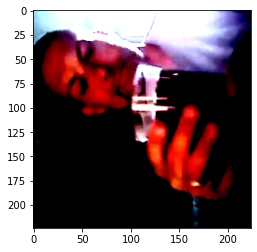

In [55]:
plt.imshow(sample["frames"][0, :, 0, :, :].transpose(0, 2))

In [80]:
# ResNet - ImageNet - VAL
dataset = datasets.Kinetics(
    subset="val",
    return_video=True,
    video_clip_duration=0.5,
    video_fps=16,
    video_transform=video_transform,
    return_audio=True,
    audio_clip_duration=2,
    audio_fps=24000,
    audio_fps_out=64,
    audio_transform=audio_transform,
    max_offsync_augm=0,
    return_labels=True,
    return_index=True,
    mode='clip',
    clips_per_video=10,
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
    sampler=None
)

resnet = resnet50(pretrained=True)

labels_val_resnet = []
codings_val_resnet = []
for sample in dataloader:
    with torch.no_grad():
        frame_id = sample["frames"].shape[2] // 2
        logits_resnet = resnet(sample["frames"][:, :, frame_id, :, :])
        codings_val_resnet.append(logits_resnet)
        labels_val_resnet += [l.split("?")[-1] for l in sample["label"]]
        print(len(labels_val_resnet))
        
codings_val_resnet = torch.vstack(codings_val_resnet)

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3050


In [81]:
# ResNet - ImageNet - TEST
dataset_test = datasets.Kinetics(
    subset="test",
    return_video=True,
    video_clip_duration=0.5,
    video_fps=16,
    video_transform=video_transform,
    return_audio=True,
    audio_clip_duration=2,
    audio_fps=24000,
    audio_fps_out=64,
    audio_transform=audio_transform,
    max_offsync_augm=0,
    return_labels=True,
    return_index=True,
    mode='clip',
    clips_per_video=10,
)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
    sampler=None
)

labels_test_resnet = []
codings_test_resnet = []
for sample in dataloader_test:
    with torch.no_grad():
        frame_id = sample["frames"].shape[2] // 2
        logits_resnet = resnet(sample["frames"][:, :, frame_id, :, :])
        codings_test_resnet.append(logits_resnet)
        labels_test_resnet += [l.split("?")[-1] for l in sample["label"]]
        print(len(labels_test_resnet))
        
codings_test_resnet = torch.vstack(codings_test_resnet)

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3170


In [82]:
tasks = [
    ["yoga", "tai chi"],
    ["cutting watermelon", "eating watermelon"],
    ["dancing macarena", "robot dancing"],
    ["playing bass guitar", "playing guitar", "strumming guitar", "tapping guitar"],
    ["playing clarinet", "playing flute"],
    ["skiing (not slalom or crosscountry)", "skiing crosscountry", "skiing slalom"],
    ["swimming backstroke", "swimming breast stroke", "swimming butterfly stroke"],
]

for task in tasks:
    print(f"\n{task}")
    
    val_mask = [l in task for l in labels_val_resnet]
    X_val = codings_val_resnet[val_mask, :]
    y_val = list(itertools.compress(labels_val_resnet, val_mask))
    
    test_mask = [l in task for l in labels_test_resnet]
    X_test = codings_test_resnet[test_mask, :]
    y_test = list(itertools.compress(labels_test_resnet, test_mask))

    linreg = LogisticRegression()
    linreg.fit(X_val, y_val)
    preds = linreg.predict_proba(X_test)
    print(f"Accuracy: {linreg.score(X_test, y_test)}")
    print(f"ROC AUC: {roc_auc_score(pd.get_dummies(y_test), preds)}")



['yoga', 'tai chi']
Accuracy: 0.7607142857142857
ROC AUC: 0.8336842105263158

['cutting watermelon', 'eating watermelon']
Accuracy: 0.8263665594855305
ROC AUC: 0.9049689440993789

['dancing macarena', 'robot dancing']
Accuracy: 0.646875
ROC AUC: 0.7374117647058824

['playing bass guitar', 'playing guitar', 'strumming guitar', 'tapping guitar']


/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Accuracy: 0.3905579399141631
ROC AUC: 0.6421332305284879

['playing clarinet', 'playing flute']
Accuracy: 0.8482758620689655
ROC AUC: 0.9124019607843137

['skiing (not slalom or crosscountry)', 'skiing crosscountry', 'skiing slalom']
Accuracy: 0.8333333333333334
ROC AUC: 0.9083124999999999

['swimming backstroke', 'swimming breast stroke', 'swimming butterfly stroke']
Accuracy: 0.36607142857142855
ROC AUC: 0.49459236209103524


/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/